In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pypfopt import EfficientFrontier, expected_returns, risk_models
import warnings
import yfinance as yf

start_date = '2006-01-01'
end_date = '2021-12-31'

# Optionally disable warnings (use cautiously)
warnings.filterwarnings("ignore")

# === Configuration ===
data_path = '/Users/benjaminli/Code/MyTradingProjects/DRL_Portfolio_Optimisation/DRL-Portfolio-Optimisation/data'
sector_etfs = ['XLE', 'XLF', 'XLK', 'XLI', 'XLV', 'XLY', 'XLP', 'XLU', 'XLRE', 'XLB', 'XLC']
benchmark = 'SPY'
tickers_to_load = sector_etfs

# # === Load and combine adjusted close prices ===
# prices = pd.DataFrame()

# for ticker in tickers_to_load:
#     file_path = os.path.join(data_path, f"{ticker}.csv")
#     df = pd.read_csv(file_path, index_col="Date", parse_dates=True)
#     prices[ticker] = df["Adj Close"]


ohlc = yf.download(tickers_to_load, start=start_date, end=end_date, auto_adjust=False)

prices = ohlc["Adj Close"].dropna(how="all")
prices.replace([np.inf, -np.inf], np.nan, inplace=True)
prices.fillna(10, inplace=True)
prices



[*********************100%***********************]  11 of 11 completed


Ticker,XLB,XLC,XLE,XLF,XLI,XLK,XLP,XLRE,XLU,XLV,XLY
Date,,,,,,,,,,,
2006-01-03,20.255623,10.000000,30.129414,17.763968,21.745029,16.536196,14.134384,10.000000,16.358212,23.101507,25.836203
2006-01-04,20.380102,10.000000,30.215166,17.747417,21.800026,16.730198,14.182623,10.000000,16.383772,23.331720,25.859690
2006-01-05,20.347342,10.000000,29.832119,17.808094,21.765646,16.807798,14.110259,10.000000,16.276430,23.274172,25.883171
2006-01-06,20.563526,10.000000,30.563902,17.912924,21.848146,17.071627,14.170562,10.000000,16.450237,23.425259,26.094561
2006-01-09,20.556973,10.000000,30.529598,17.962572,22.026894,17.125954,14.236893,10.000000,16.347988,23.533169,26.360752
...,...,...,...,...,...,...,...,...,...,...,...
2021-12-23,82.627800,75.593323,48.778637,36.604786,98.586296,168.333374,69.131424,44.710258,63.043251,132.295166,197.515945
2021-12-27,83.872231,76.328857,49.844841,36.981953,99.629837,171.944550,69.866386,45.623806,63.350693,133.691223,199.440643
2021-12-28,84.358765,76.290146,49.809299,37.000820,100.132629,171.049042,70.261429,45.820854,63.920361,133.339813,199.528137


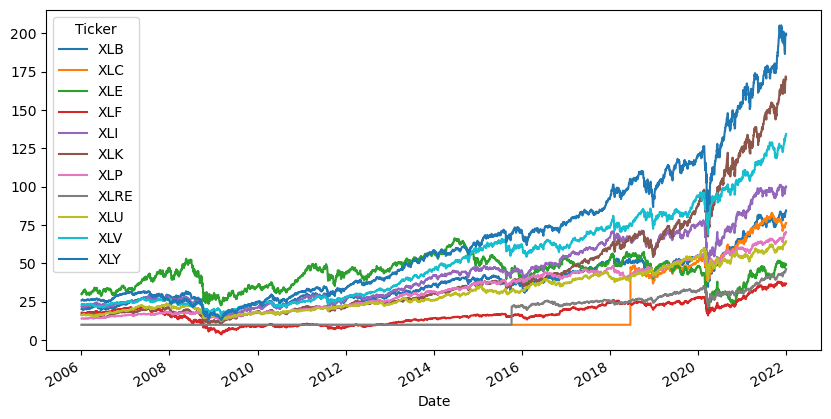

In [20]:
prices[(prices.index >= "2006-01-01") & (prices.index <= "2021-12-31")].plot(figsize=(10, 5));

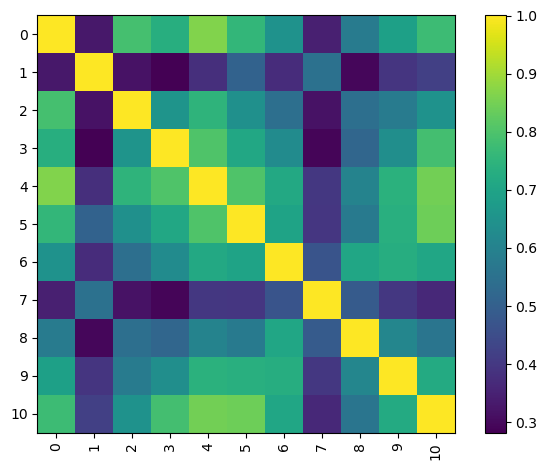

In [27]:
import numpy as np
import pandas as pd
from pypfopt import expected_returns, risk_models, plotting
from pypfopt.efficient_frontier import EfficientFrontier

# === PSD Fix Function ===
def make_psd(matrix):
    eigvals, eigvecs = np.linalg.eigh(matrix)
    eigvals[eigvals < 0] = 0.0
    psd_matrix = eigvecs @ np.diag(eigvals) @ eigvecs.T
    psd_matrix = (psd_matrix + psd_matrix.T) / 2  # Ensure symmetry
    return psd_matrix

# === Step 1: Get expected returns ===
mu = expected_returns.mean_historical_return(prices)
# mu = expected_returns.capm_return(prices)

# === Step 2: Ledoit-Wolf shrinkage covariance ===
shrinked_cov = risk_models.CovarianceShrinkage(prices).ledoit_wolf()

# === Step 3: Enforce PSD ===
psd_cov = make_psd(shrinked_cov)

plotting.plot_covariance(psd_cov, plot_correlation=True);



In [28]:

# === Step 4: Optimize portfolio (with optional bounds) ===
bounds = (0.05, 0.3)  # Example: 0% to 20% per asset

ef = EfficientFrontier(mu, psd_cov, weight_bounds=bounds)

ef.max_sharpe()

# Get the optimized portfolio weights as numbers
weights = ef.clean_weights()
print("Optimized Portfolio Weights (in numbers):")
for ticker, weight in weights.items():
    print(f"{ticker}: {weight:.4f}")

# Get performance stats: expected annual return, annual volatility, Sharpe ratio
rets, vol, sharpe = ef.portfolio_performance(verbose=False)

print("\nOptimized Portfolio Performance:")
print(f"Expected Annual Return: {rets*100:.2f}%")
print(f"Annual Volatility: {vol*100:.2f}%")
print(f"Sharpe Ratio: {sharpe:.2f}")


Optimized Portfolio Weights (in numbers):
XLB: 0.0500
XLC: 0.3000
XLE: 0.0500
XLF: 0.0500
XLI: 0.0500
XLK: 0.0500
XLP: 0.0500
XLRE: 0.2500
XLU: 0.0500
XLV: 0.0500
XLY: 0.0500

Optimized Portfolio Performance:
Expected Annual Return: 12.03%
Annual Volatility: 12.59%
Sharpe Ratio: 0.96


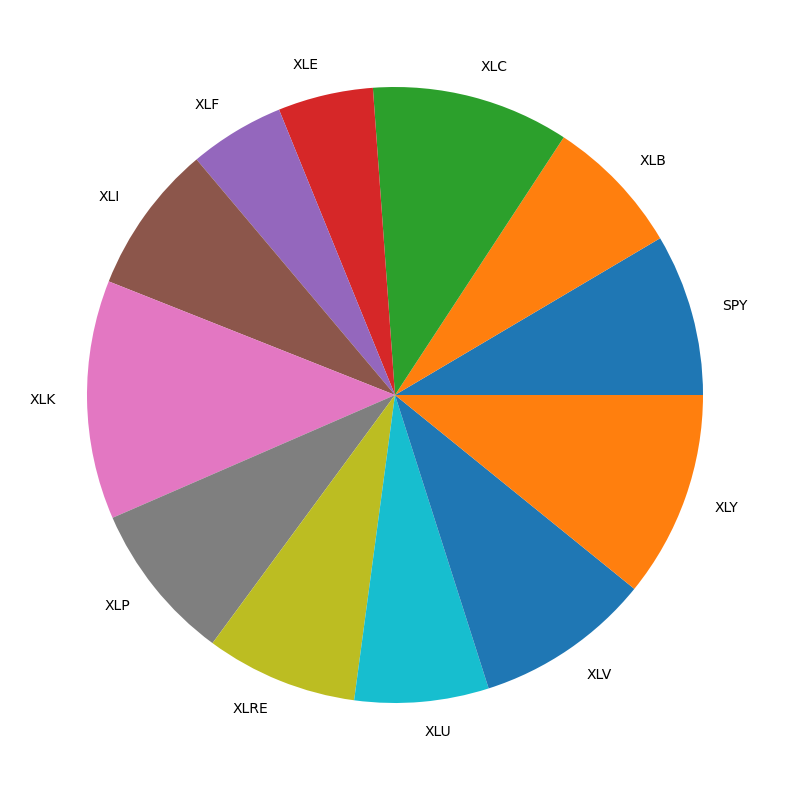

In [14]:
pd.Series(weights).plot.pie(figsize=(10,10));

[*********************100%***********************]  11 of 11 completed


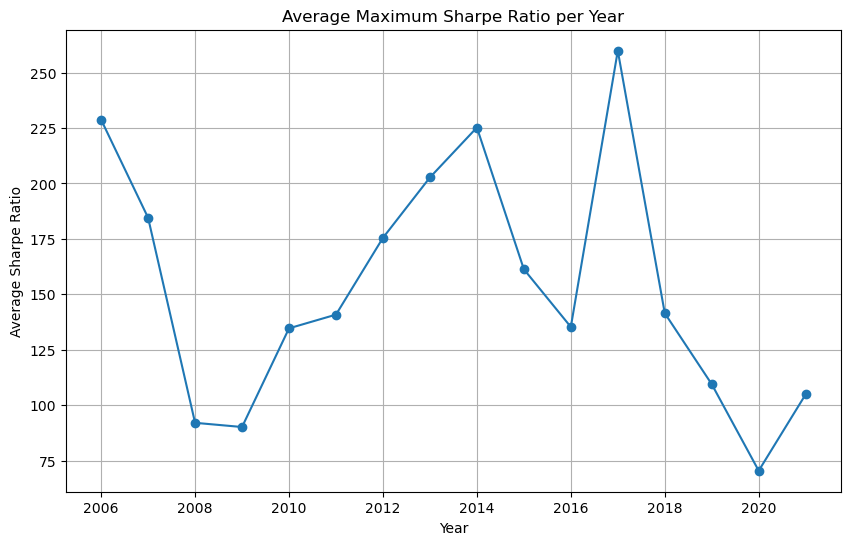

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pypfopt import EfficientFrontier, expected_returns, risk_models
import yfinance as yf
import warnings

# Optionally disable warnings
warnings.filterwarnings("ignore")

# === Configuration ===
start_date = '2006-01-01'
end_date = '2021-12-31'
sector_etfs = ['XLE', 'XLF', 'XLK', 'XLI', 'XLV', 'XLY', 'XLP', 'XLU', 'XLRE', 'XLB', 'XLC']
benchmark = 'SPY'
tickers_to_load = sector_etfs

# Download historical data
ohlc = yf.download(tickers_to_load, start=start_date, end=end_date, auto_adjust=False)
prices = ohlc["Adj Close"].dropna(how="all")

# Set the lookback period (60 days)
lookback = 60

# Dictionary to store Sharpe ratio for each day
daily_sharpe = {}

# Loop over each day starting from the first day with at least 60 days of data
for current_date in prices.index[lookback:]:
    # Extract the last 'lookback' days of data up to the current_date
    window_prices = prices.loc[:current_date].iloc[-lookback:]
    
    # Ensure we have a complete window (this is mostly redundant)
    if len(window_prices) < lookback:
        continue
    
    try:
        # === PSD Fix Function ===
        def make_psd(matrix):
            eigvals, eigvecs = np.linalg.eigh(matrix)
            eigvals[eigvals < 0] = 0.0
            psd_matrix = eigvecs @ np.diag(eigvals) @ eigvecs.T
            psd_matrix = (psd_matrix + psd_matrix.T) / 2  # Ensure symmetry
            return psd_matrix

        # === Step 1: Get expected returns ===
        mu = expected_returns.mean_historical_return(window_prices)

        # === Step 2: Ledoit-Wolf shrinkage covariance ===
        shrinked_cov = risk_models.CovarianceShrinkage(window_prices).ledoit_wolf()

        # === Step 3: Enforce PSD ===
        psd_cov = make_psd(shrinked_cov)
        
        ef = EfficientFrontier(mu, psd_cov, weight_bounds=bounds)
        ef.max_sharpe(risk_free_rate=-10)
        
        # Obtain the performance metrics (return, volatility, Sharpe ratio)
        rets, vol, sharpe = ef.portfolio_performance(verbose=False)
        
        # Store the Sharpe ratio for the current date
        daily_sharpe[current_date] = sharpe
        
    except Exception as e:
        print(f"Error on {current_date}: {e}")

# Convert dictionary to a Pandas Series
daily_sharpe_series = pd.Series(daily_sharpe)
daily_sharpe_series.index = pd.to_datetime(daily_sharpe_series.index)
daily_sharpe_series = daily_sharpe_series.sort_index()

# Compute average Sharpe ratio for each year
annual_sharpe = daily_sharpe_series.resample('Y').mean()

# Plot the annual average Sharpe ratio as a line graph
plt.figure(figsize=(10, 6))
plt.plot(annual_sharpe.index.year, annual_sharpe.values, marker='o', linestyle='-')
plt.title("Average Maximum Sharpe Ratio per Year")
plt.xlabel("Year")
plt.ylabel("Average Sharpe Ratio")
plt.grid(True)
plt.show()
